# Text Classificaiton

<div style="border: 2px solid #e0e0e0; border-radius: 10px; padding: 15px; margin: 15px 0;">
  <p>
    Chris Andrei Irag<br>
    DS4A, University of Science and Technology of Southern Philippines<br>
    <a href="mailto:iragca@pm.me">iragca@pm.me</a><br><br>
    November 23, 2025
 </p>
</div>



## Executive Summary

This notebook is an assignment for DS411 Predictive Analytics. The initial data exploration of the Amazon Product Reviews dataset informed the following discussion of potential preprocessing and feature engineering techniques. This notebook focuses on a binary classification task of predicted whether an Amazon product review either has a negative or positive sentiment where we use a deep neural network with test set accuracy 0.76. We discussed the model performance and challenges. We proposed 3 classification threshold strategies for 3 separate use cases.


---

## Table of Contents


```bash
.
├── Title Section         
│       ├── Executive Summary
│       └── Table of Contents   #  ⭐ You are here
├── About the data
│       ├── Exploration
│       ├── Preprocessing
│       └── Splitting the dataset
├── Modeling
├── Results and Discussion
└── Summary
```


# About the data

The data comes with no information, other than the names of its columns and the values themselves. The data seemingly contains Amazon reviews about various products. Each review has either one of 2 labels: (1) Negative or 0, the text's sentiment is inherently negative about the product. (2) Positive or 1, the text's sentiment is inherently positive about the product.

The following code loads the data using `pandas`, the data being stored locally on the hard drive, named `amazon_cells_labelled.txt` at the time of writing this notebook located at wherever the `pathlib.Path` object `DirectoryPaths.EXTERNAL_DATA.value` points to. The file has no headers and is a `TAB` separated file, as such we specify it to `pandas` using the escape character `\t`.

Learn more about them: [Escape characters](https://en.wikipedia.org/wiki/Escape_character),  [pandas](https://pandas.pydata.org/), [pathlib](https://docs.python.org/3/library/pathlib.html)

In [2]:
import pandas as pd

from src.config import DirectoryPaths

data_path = DirectoryPaths.EXTERNAL_DATA.value / "amazon_cells_labelled.txt"

df = pd.read_csv(data_path, sep="\t", header=None, names=["text", "label"])
df.head()

2025-11-23 20:48:10.520 | INFO     | src.config:<module>:24 - Loaded environment variables from /home/iragca/Documents/github/DS411-Predictive-Analytics/.env
2025-11-23 20:48:10.521 | INFO     | src.config:<module>:47 - PROJECT_ROOT: /home/iragca/Documents/github/DS411-Predictive-Analytics
2025-11-23 20:48:10.521 | INFO     | src.config:<module>:48 - DATA_DIR: /home/iragca/Documents/github/DS411-Predictive-Analytics/data


,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [3]:
print(f"Number of rows: {len(df)}\nNumber of columns: {len(df.columns)}")
print(f"Columns: {df.columns.tolist()}")

Number of rows: 1000
Number of columns: 2
Columns: ['text', 'label']


Our data has 1000 samples, and 2 columns.

- `text`: The text of the review.
- `label`: The sentiment label of the text

## Exploration

We will do some exploration to inform us of our data what actions we could take to improve the downstream classification task.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from iragca.matplotlib import Styles

plt.style.use(Styles.ML.value)

([<matplotlib.axis.XTick at 0x7fd824f15580>,
 [Text(0, 0, 'Negative (0)'), Text(1, 0, 'Positive (1)')])

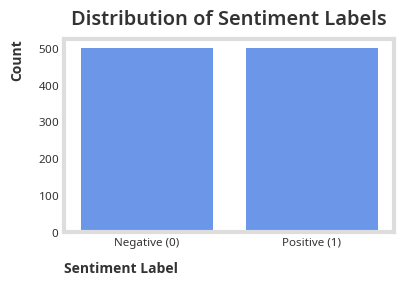

In [5]:
sns.countplot(data=df, x="label")
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label", fontweight="bold")
plt.ylabel("Count", fontweight="bold")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])

We can see that our classes are balanced and we will not need to do any sampling techniques.

Text(0, 1, 'Frequency')

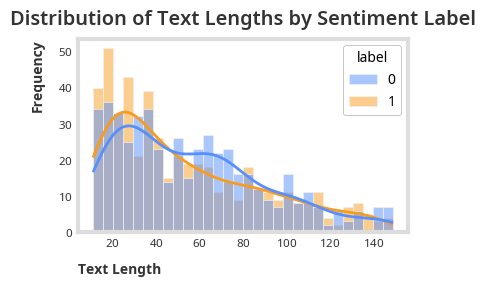

In [6]:
df["text_lengths"] = df["text"].apply(len)

sns.histplot(data=df, x="text_lengths", hue="label", bins=30, kde=True)
plt.title("Distribution of Text Lengths by Sentiment Label")
plt.xlabel("Text Length", fontweight="bold")
plt.ylabel("Frequency", fontweight="bold")

We can observe that positive reviews tend to be shorter than negative reviews, around the 10-40 text length range are where positive reviews tend to bias in. Negative reviews bias around 50-80, while further lengths are observed to have no bias between the two classes, meaning both types of reviews show no observable difference in text lengths around 90 and beyond.

This information can be used as a new feature, or not, since there is a possibility where the model can discover this latent feature by itself because the length is just a sum of words in the document, and the whole document is already the input itself.

## Preprocessing

Let's now preprocess our data for model consumption.

We will use `scikit-learn`'s CountVectorizer object to turn our documents in to a bag of words. 

Learn more: [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = np.asarray(vectorizer.fit_transform(df["text"]).todense())
y = df["label"]

In [8]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1000, 1847))

In [9]:
word_freq: np.ndarray = X.sum(axis=0)
word_freq

array([ 4,  1,  1, ..., 32,  1,  1], shape=(1847,))

Text(0.5, 1.0, 'Top 20 Most Frequent Words')

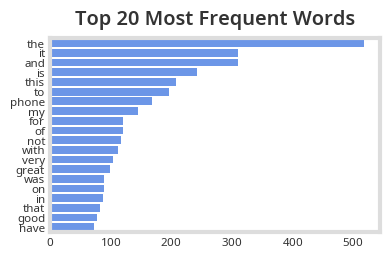

In [10]:
import torch

words = vectorizer.get_feature_names_out()
sorted_freq = torch.tensor(word_freq).sort(descending=True)

word_freq_dict = {
    words[idx]: int(word_freq[idx]) for idx in sorted_freq.indices.tolist()
}
top_k = 20
sns.barplot(
    x=list(word_freq_dict.values())[:top_k],
    y=list(word_freq_dict.keys())[:top_k],
    orient="h"
)
plt.title(f"Top {top_k} Most Frequent Words")

We can see that most of the top 20 most frequent words are stop words, so have a choice to remove them or not to remove noise and reduce dimensionality.

Text(0, 1, 'Count')

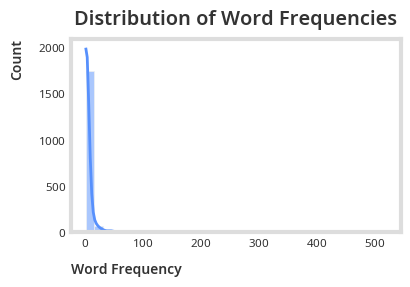

In [11]:
sns.histplot(word_freq, bins=35, kde=True)
plt.title("Distribution of Word Frequencies")
plt.xlabel("Word Frequency")
plt.ylabel("Count")

We can see that our word frequencies is very skewed.

Text(0.5, 1.0, 'Distribution of Word Frequencies (Zoomed In 0-10)')

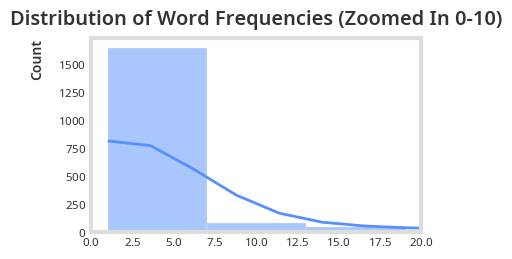

In [12]:
sns.histplot(word_freq, kde=True)
plt.xlim(0, 20)
plt.title("Distribution of Word Frequencies (Zoomed In 0-10)")

In [13]:
def quantile(data: np.ndarray, q: float) -> float:
    """Calculate the q-th quantile of the given data."""
    sorted_data = np.sort(data)
    index = int(q * (len(sorted_data) - 1))
    return sorted_data[index]

quantiles = {q: quantile(word_freq, q) for q in [0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]}
quantiles

{0.25: np.int64(1),
 0.5: np.int64(1),
 0.75: np.int64(3),
 0.9: np.int64(8),
 0.95: np.int64(18),
 0.96: np.int64(20),
 0.97: np.int64(26),
 0.98: np.int64(34),
 0.99: np.int64(73)}

Text(0, 0, 'Word Frequency')

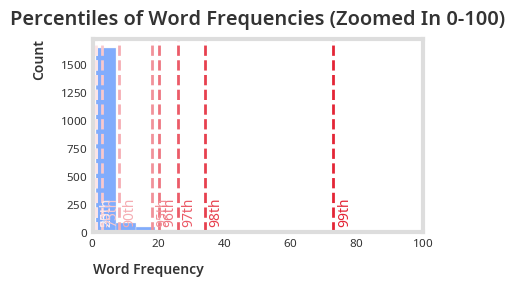

In [14]:
import matplotlib.colors as colors
from iragca.matplotlib import Color

sns.histplot(word_freq)

cmap = Color.WhRd()
norm = colors.Normalize(vmin=0, vmax=len(quantiles)-1)

for index, (q, value) in enumerate(quantiles.items()):
    color = cmap(norm(index))

    plt.axvline(
        x=value,
        linestyle="--",
        linewidth=2,
        color=color,
        label=f"{int(q*100)}",
    )
    plt.text(
        x=value + 1,
        y=50,
        s=f"{int(q*100)}th",
        color=color,
        fontsize=10,
        rotation=90,
        va="bottom",
    )

plt.xlim(0, 100)
plt.title("Percentiles of Word Frequencies (Zoomed In 0-100)")
plt.xlabel("Word Frequency")

We can see that 95% of the words appear less then 20 times in our data set. We have a choice to remove those rare or othwerise commons words.

## Splitting the dataset

We will split the disjointly and randomly into 3 separate datasets: (1) training, (2) validation, (3) testing, with ratios of 0.7, 0.2 , 0.1 respectively. A use dataloaders to pass through the data using chunks or batches with a size of 16, to efficiently use hardware resources when training.

In [15]:
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))

train_set, val_set, test_set = random_split(dataset, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 16
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

# Modeling

In this section, we will formalize the training loop and use a deep neural network to perform binary classification.

In [16]:
from iragca.ml import RunLogger


def train(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    logger = RunLogger(num_epochs, display_progress=True, update_interval=10)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        logger.pbar.set_description("Training  ")

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0) 
            train_loss += loss.item() * inputs.size(0)

        train_accuracy = correct / total
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        logger.pbar.set_description("Validating")

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = outputs >= 0.5
                val_correct += (preds.float() == labels).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item() * inputs.size(0)

        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader.dataset)

        logger.log_metrics(
            {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
            },
            epoch,
        )

    return logger

We will use a deep neural network of 3 linear layers. The first 2 linear layers are activated using ReLU (Rectified linear Unit). With layer norm to prevent gradient epxlosion or death, we also use a drop of 0.4 to reduce overfitting.

Learn more: [ReLU](https://en.wikipedia.org/wiki/Rectified_linear_unit)

In [17]:
from torch import nn


class TextClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super(TextClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.4),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.4),

            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


Since this task is binary classification, we could have used a sigmoid activation function on the last layer, but since we are using `BCEWithLogitsLoss`, pytorch will apply it for us along with the BCE (Binary Cross Entropy) loss function. This loss function is what essentially teaches the model what is wrong or right.

Learn more: [Cross entropy](https://en.wikipedia.org/wiki/Cross-entropy)

Validating: 100%|██████████| 200/200 [00:19<00:00, 10.15it/s, train_loss=0.0075, val_loss=1.5, train_accuracy=0.997, val_accuracy=0.78]  


<Axes: >

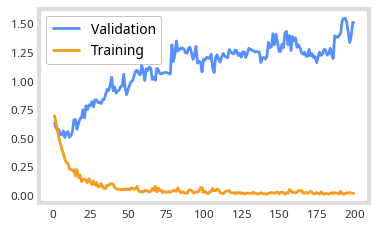

In [18]:
model = TextClassifier(input_dim=X.shape[1], hidden_dim=16, output_dim=1)

results = train(
    train_loader,
    val_loader,
    model,
    criterion=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=1e-4
    ),
    num_epochs=200,
)

sns.lineplot(x=results.steps, y=results.val_loss, label="Validation")
sns.lineplot(x=results.steps, y=results.train_loss, label="Training")

<Axes: >

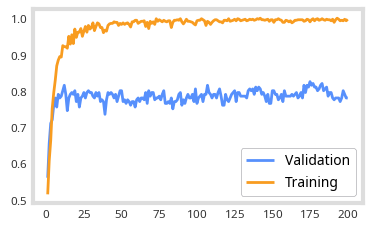

In [19]:
sns.lineplot(x=results.steps, y=results.val_accuracy, label="Validation")
sns.lineplot(x=results.steps, y=results.train_accuracy, label="Training")

Using 200 epochs (or 200 passes over the data), we get a validation accuracy of 0.75, however loss is increasing linearly, while accuracy fails to converge beyond 0.75, so it might be better to do an early stop around 25 epochs to prevent over fitting.

Validating: 100%|██████████| 25/25 [00:02<00:00,  9.49it/s, train_loss=0.197, val_loss=0.552, train_accuracy=0.924, val_accuracy=0.79] 


<Axes: >

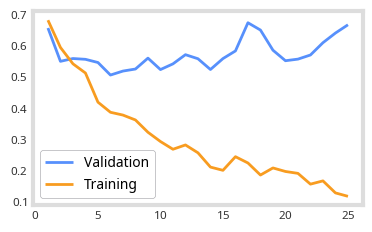

In [24]:
model = TextClassifier(input_dim=X.shape[1], hidden_dim=16, output_dim=1)

results = train(
    train_loader,
    val_loader,
    model,
    criterion=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=1e-4
    ),
    num_epochs=25,
)

sns.lineplot(x=results.steps, y=results.val_loss, label="Validation")
sns.lineplot(x=results.steps, y=results.train_loss, label="Training")

# Results & Discussion

In [25]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
for input, label in test_loader:
    input, label = input.to(device).to(torch.float32), label.to(device).to(torch.float32).unsqueeze(1)
    
    output = model(input)
    preds = output >= 0.5
    
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(label.cpu().numpy())
print("Accuracy on Test Set: ", np.mean(np.array(all_preds) == np.array(all_labels)))
print(classification_report(all_labels, all_preds))

Accuracy on Test Set:  0.76
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        57
         1.0       0.72      0.72      0.72        43

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

precision_list = []
recall_list = []
f1_list = []

thresholds = np.arange(0.1, 1, 0.1)
for thres in thresholds:
    all_preds = []
    all_labels = []

    model.eval()
    for input, label in test_loader:
        input, label = input.to(device).to(torch.float32), label.to(device).to(torch.float32).unsqueeze(1)
        
        output = torch.sigmoid(model(input))
        preds = output >= thres
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

Text(0.5, 1.0, 'Precision, Recall, and F1 Score vs. Classification Threshold')

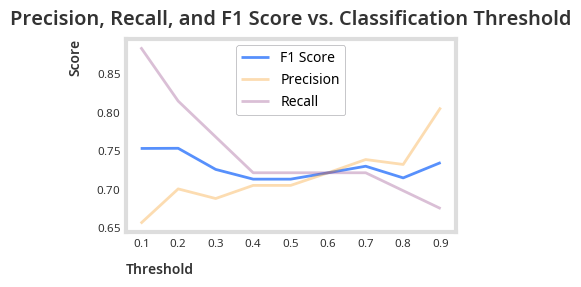

In [29]:
sns.lineplot(x=thresholds, y=f1_list, label="F1 Score")
sns.lineplot(x=thresholds, y=precision_list, label="Precision", color=Color.ORANGE.value, alpha=0.35)
sns.lineplot(x=thresholds, y=recall_list, label="Recall", color=Color.PURPLE.value, alpha=0.35)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Classification Threshold")

Looking at the threshold curve, we can see that it is most balanced around 0.5, so we will not be changing our classification threshold. If we were to maximize recall by choosing 0.1 or 0.2, we have the consequence of a significant decrease in precision. Depending on the use case, we can optimize each metric by choosing 3 different thresold strategies.

| Threshold Strategy | Objective          |
|--------------------|--------------------|
| 0.1 - 0.3          | Maximize Recall    |
| 0.5 - 0.6          | Balanced           |
| 0.9                | Maximize Precision |

# Summary

Bag-of-words representation of the Amazon Review dataset modeled by a 3 layer deep neural network results in a testing set accuracy of 0.76 at a threshold of 0.5. Although 3 threshold strategies where presented to maximize either of recall and precision, or strike a balance between the two. The dataset was explored and some preprocessing stragies were formulated but nothing was done other than the making of a bag of words representation.